In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import prim
from matplotlib import patches
from sklearn import metrics

In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
np.random.seed(35)

In [3]:
df = pd.read_csv('/home/fotis/DATA/regions/Activity recognition exp/Watch_accelerometer.csv', header=0, index_col=0)

/home/fotis/anaconda3/envs/data_vis/lib/python3.5/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.head(5)

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
Index,,,,,,,,,
0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [5]:
df['gt'].value_counts()

bike          635530
walk          549761
stairsdown    486376
stairsup      473754
stand         451189
sit           423995
Name: gt, dtype: int64

In [6]:
df.groupby(['gt'])[['x','y','z']].mean()

,x,y,z
gt,,,
bike,-1.803119,-1.947162,4.590256
sit,0.324850,-4.766640,3.917400
stairsdown,-0.607346,-1.976259,0.816490
stairsup,-0.024106,-2.113122,0.868505
stand,-0.357810,-2.287680,1.118905
walk,-0.317929,-2.276931,0.707096


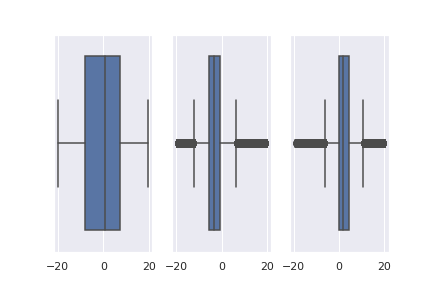

In [7]:
fig = plt.figure()
ax = fig.add_subplot(131)
sns.boxplot(df[['x']],ax=ax)
ax = fig.add_subplot(132)
sns.boxplot(df[['y']],ax=ax)
ax = fig.add_subplot(133)
sns.boxplot(df[['z']],ax=ax)

In [8]:
df['gt']=df['gt'].astype('category')

In [9]:
df['int_enc'] = df['gt'].cat.codes

In [10]:
X = df[['x','y','z']].dropna().values
y = df['int_enc'].apply(lambda x: 1 if x==4 else 0)

In [11]:
df['int_enc'].value_counts()

 0    635530
 5    549761
-1    520357
 2    486376
 3    473754
 4    451189
 1    423995
Name: int_enc, dtype: int64

In [12]:
min_ = np.min(X, axis=0)
max_ = np.max(X, axis=0)
X = (X-min_) / (max_-min_) 

In [13]:
data = np.column_stack((X,y))

In [14]:
x = np.linspace(0.1,0.9,7)
xx,yy,zz = np.meshgrid(x,x,x)

In [16]:
cov = np.identity(3)*0.001
cluster_centers = np.column_stack((xx.ravel(),yy.ravel(),zz.ravel()))
query_centers = []
#Generate queries over cluster centers
for c in cluster_centers:
    queries = np.random.multivariate_normal(np.array(c), cov, size=40)
    query_centers.append(queries)
query_centers = np.array(query_centers).reshape(-1,3)

In [17]:
ranges = np.random.uniform(low=0.005**(1/3), high=0.25**(1/3), size=(query_centers.shape[0], 3))
# ranges = np.ones((query_centers.shape[0], 3))*ranges

In [18]:
from codebase.query_generation import generate_boolean_vector

In [19]:
queries = []
empty = 0
for q,r in zip(query_centers,ranges):
        b = generate_boolean_vector(data,q,r,3)
        res = data[b]
        if res.shape[0]==0:
            empty+=1
#             print(q,r)
#             break;
        ans = float(np.mean(res[:,-1])) if res.shape[0]!=0 else 0
        qt = q.tolist()
        qt += r.tolist()
        qt.append(ans)
        queries.append(qt)

In [20]:
qs = np.array(queries).reshape(-1, 7)

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


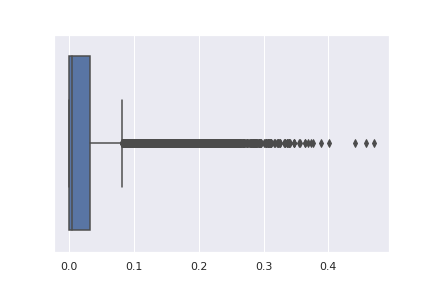

In [21]:
sns.boxplot(qs[:,-1])

In [34]:
from scipy.stats import gaussian_kde

In [35]:
empirical_cdf = gaussian_kde(qs[:,-1],)
print(empirical_cdf.d)
print(empirical_cdf.n)
empirical_cdf.set_bandwidth(0.001)

1
13720


In [38]:
outliers = qs[qs[:,-1]>0.1]
normal = qs[qs[:,-1]<0.1]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
     qs[:,:qs.shape[1]-1], qs[:,-1], test_size=0.2, random_state=0)

In [41]:
xgb1 = XGBRegressor(max_depth=8,n_estimators=150,reg_lambda=0.5)
xgb1.fit(X_train, y_train)
print(np.sqrt(metrics.mean_squared_error(y_train, xgb1.predict(X_train))))
r2 = xgb1.score(X_test, y_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, xgb1.predict(X_test)))
print(r2)
print(rmse)

[11:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.008770229273344358
0.8942883139567607
0.02103984021705604


In [42]:
import copy
from Optimization_Methods.GlowWorm import GlowWorm

In [43]:
yreq = 0.3

In [44]:
def objective_aggr_over_real(X):
    b = generate_boolean_vector(data,X.flatten()[:3],X.flatten()[3:],3)
    res_ = np.mean(data[b,-1])
    ans = np.log(res_-yreq) - 3*np.sum(np.log(1+X.flatten()[3:]))
    return ans if not np.isnan(ans) else res_-yreq
def objective_aggr(X):
    assert X.shape[1]==6
    res = np.log(xgb1.predict(X) - yreq) - 3*np.sum(np.log(1+X[:,X.shape[1]//2:]),axis=1)
    res[np.isnan(res)] = xgb1.predict(X[np.isnan(res)]) - yreq
    return res
gw = GlowWorm(objective_aggr, dimensions=6, nt=5, iter_max=150, glowworms=150, r0=0.38)
# gw_ad = GlowWormDensity(objective_aggr, dimensions=6, nt=5, iter_max=100, glowworms=100, r0=0.4, probx=probability_of_data)
initial = copy.copy(gw.X)
# initial_ad = copy.copy(gw_ad.X)
pos = gw.optimize()
# pos_ad = gw_ad.optimize()

/home/fotis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


In [46]:
w_pos = pos[np.argsort(-objective_aggr(pos))][:10]
# list(zip(w_pos, objective_aggr(w_pos), xgb1.predict(w_pos)))

/home/fotis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


In [48]:
for box3d,obj,yhat in zip(pos, objective_aggr(pos), xgb1.predict(pos)):
#     print(box3d)
    b = generate_boolean_vector(data,box3d[:3],box3d[3:],3)
    res = data[b]
    ytrue = np.mean(res[:,-1])
    if not ytrue>yreq:
        continue;
    print(box3d)
    print("True Result {0}\t Prediction={1}\tJ(x,l)={2}".format(ytrue,yhat,obj))
    print("Is it over y_req ? : {0}".format(ytrue>yreq))
#     break;

/home/fotis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


[0.71838147 0.4805733  0.16353285 0.65320939 0.47181494 0.47266493]
True Result 0.3014976353126642	 Prediction=0.2430325448513031	J(x,l)=-0.056967467069625854
Is it over y_req ? : True


/home/fotis/anaconda3/envs/data_vis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/fotis/anaconda3/envs/data_vis/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
